## Gather the data

In [1]:
import numpy as np
import pickle
from simtk.openmm import unit
from openmmtools.constants import kB
import pandas as pd

import matplotlib.pyplot as plt
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [2]:
def compute_ddg(dg_A, dg_B):
    return dg_A * KT_KCALMOL - dg_B * KT_KCALMOL

def compute_error(ddg_A, ddg_B):
    return (ddg_A**2 + ddg_B**2)**0.5 * KT_KCALMOL

In [3]:
# Retrieve free energies

main_dir = 46
sub_dirs = list(range(4, 9)) + list(range(14, 19)) + list(range(24, 29)) + list(range(34, 39))
d_results = {}
for sub_dir in sub_dirs:
    d_results[sub_dir] = {}
    for phase in ['apo']:
        with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_3/{phase}_free_energy_bootstrapped_10ns.pickle", "rb") as f:
            results = pickle.load(f)
            d_results[sub_dir][phase] = results


In [4]:
# Format the data appropriately for cinnabar

titles = ["Y2F", "Y2A", "W2F", "T2A", "E2A", "D2A", "K2A", "R2A", "R2Q", "H2A", "F2Y", "A2Y", "F2W", "A2T", "A2E", "A2D", "A2K", "A2R", "Q2R", "A2H"]

to_plot = []

for sub_dir in list(range(4, 9)) + list(range(14, 19)):
    ddg = compute_ddg(d_results[sub_dir]['apo']["Deltaf"][0, -1], d_results[sub_dir + 20]['apo']["Deltaf"][0, -1])
    dddg = compute_error(d_results[sub_dir]['apo']["dDeltaf"][0, -1], d_results[sub_dir + 20]['apo']["dDeltaf"][0, -1])
    if sub_dir in range(10):
        to_plot.append([titles[sub_dir][:-1], titles[sub_dir][-1] + titles[sub_dir][1:-1], ddg, dddg*2, 0])
    else:
        to_plot.append(["-" + titles[sub_dir][:-1], "-" + titles[sub_dir][-1] + titles[sub_dir][1:-1], ddg * -1, dddg*2, 0])

        

In [5]:
d_results[4]["apo"]["dDeltaf"][0, -1]

0.7818240241787794

In [6]:
d_results[14]["apo"]["dDeltaf"][0, -1]

0.871571252110666

In [7]:
to_plot

[['E2', 'A2', 5.035597344717984, 1.3038992899396413, 0],
 ['D2', 'A2', 5.002403147901234, 1.2798444456875788, 0],
 ['K2', 'A2', -1.6928340029847675, 1.4465497137438197, 0],
 ['R2', 'A2', -1.6114852024910675, 1.4327938288691418, 0],
 ['R2', 'Q2', -1.9746979686901476, 1.7214327838477002, 0],
 ['-A2', '-E2', 5.038717932097313, 1.4373889950489809, 0],
 ['-A2', '-D2', 5.117932315976901, 1.3656443563620482, 0],
 ['-A2', '-K2', -1.8460309117000122, 1.2224881665538032, 0],
 ['-A2', '-R2', -1.5682226729266517, 1.350785629845742, 0],
 ['-Q2', '-R2', -1.8806699253573242, 1.4882421477698986, 0]]

In [8]:
# Get the discrepancy between forward and negative reverse DDGs (including 95% CI error bars)

labels_internal_consistency = []
for i in range(5):
    discrepancy = round(to_plot[i][2] - to_plot[i+5][2], 2)
    forward_ddg = round(to_plot[i][2], 2)
    reverse_ddg = round(to_plot[i+5][2], 2)
    forward_ci = [round(to_plot[i][2] - to_plot[i][3], 2), round(to_plot[i][2] + to_plot[i][3])]
    reverse_ci = [round(to_plot[i+5][2] - to_plot[i+5][3], 2), round(to_plot[i+5][2] + to_plot[i+5][3])]
    forward_ci_extended = [forward_ci[0] - 1, forward_ci[1] + 1]
    reverse_ci_extended = [reverse_ci[0] - 1, reverse_ci[1] + 1]
    is_within_error = (forward_ci_extended[0] <= reverse_ddg and reverse_ddg <= forward_ci_extended[1]) or (reverse_ci_extended[0] <= forward_ddg and forward_ddg <= reverse_ci_extended[1])
    print(to_plot[i][0:2], discrepancy, forward_ddg, forward_ci, reverse_ddg, reverse_ci, is_within_error)
    if not is_within_error:
        labels_internal_consistency.append(titles[i])
    else:
        labels_internal_consistency.append("")
    

['E2', 'A2'] -0.0 5.04 [3.73, 6] 5.04 [3.6, 6] True
['D2', 'A2'] -0.12 5.0 [3.72, 6] 5.12 [3.75, 6] True
['K2', 'A2'] 0.15 -1.69 [-3.14, 0] -1.85 [-3.07, -1] True
['R2', 'A2'] -0.04 -1.61 [-3.04, 0] -1.57 [-2.92, 0] True
['R2', 'Q2'] -0.09 -1.97 [-3.7, 0] -1.88 [-3.37, 0] True


In [9]:
# Format data for cinnabar test
x = [round(entry[2], 3) for i, entry in enumerate(to_plot) if i < 5] # forward
y = [round(entry[2], 3) for i, entry in enumerate(to_plot) if i >= 5] # reverse
xerr =  [round(entry[3], 3) for i, entry in enumerate(to_plot) if i < 5] # forward
yerr = [round(entry[3], 3) for i, entry in enumerate(to_plot) if i >= 5] # reverse
x_data = np.asarray(x)
y_data = np.asarray(y)
print(x)
print(y)
print(xerr)
print(yerr)

[5.036, 5.002, -1.693, -1.611, -1.975]
[5.039, 5.118, -1.846, -1.568, -1.881]
[1.304, 1.28, 1.447, 1.433, 1.721]
[1.437, 1.366, 1.222, 1.351, 1.488]


In [10]:
# Get labels for charge mutations only
labels_charges = []
for i in range(10):
    if i in [4, 5, 6, 7, 8]:
        labels_charges.append(titles[i])

In [11]:
labels_charges

['E2A', 'D2A', 'K2A', 'R2A', 'R2Q']

## -Reverse vs Forward plot

In [12]:
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

from cinnabar import plotting, stats, wrangle

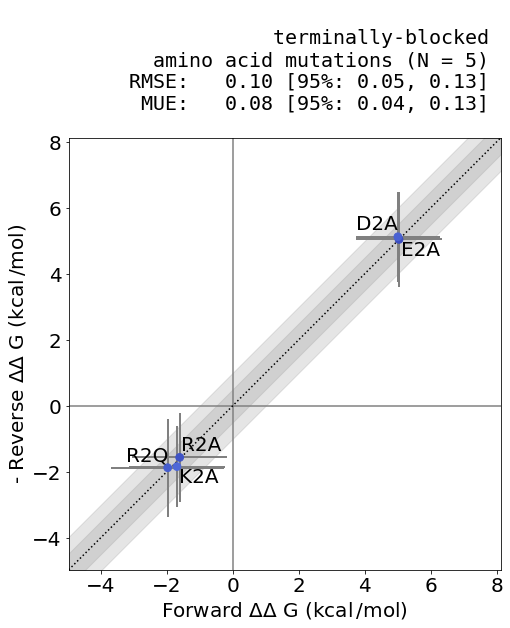

In [13]:
# Format the data appropriately
x = [entry[2] for i, entry in enumerate(to_plot) if i < 5] # forward
y = [entry[2] for i, entry in enumerate(to_plot) if i >= 5] # reverse
xerr =  [entry[3] for i, entry in enumerate(to_plot) if i < 5] # forward
yerr = [entry[3] for i, entry in enumerate(to_plot) if i >= 5] # reverse
x_data = np.asarray(x)
y_data = np.asarray(y)

# Generate the plot
filename = '/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_plot_5ns_dipeptide_more_states.pdf'
plot = plotting._master_plot(
    x_data,
    y_data,
    xerr=xerr,
    yerr=yerr,
    filename=filename,
    title="",
    target_name="terminally-blocked \namino acid mutations",
    xlabel="Forward",
    ylabel="- Reverse",
    units=r'$\mathrm{kcal\,/mol}$', 
    figsize=10, 
    dpi=500,
    axis_padding=3.0,
    data_labels=labels_charges,
    font_sizes={"title":20, "labels": 20, "other": 20},
    scatter_kwargs={'s': 60}
)


## Table

In [31]:
# Format the data appropriately for table

titles = ["Y2F", "Y2A", "W2F", "T2A", "E2A", "D2A", "K2A", "R2A", "R2Q", "H2A", "F2Y", "A2Y", "F2W", "A2T", "A2E", "A2D", "A2K", "A2R", "Q2R", "A2H"]

to_plot = []

for sub_dir in range(20):
    ddg = compute_ddg(d_results[sub_dir]['apo']["Deltaf"][0, -1], d_results[sub_dir + 20]['apo']["Deltaf"][0, -1])
    dddg = compute_error(d_results[sub_dir]['apo']["dDeltaf"][0, -1], d_results[sub_dir + 20]['apo']["dDeltaf"][0, -1])
    if sub_dir in range(10):
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), 5, 5, "forward"])
    else:
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), 5, 5, "reverse"])


In [35]:
df = pd.DataFrame(to_plot, columns=["Mutation", r"Predicted $\Delta\Delta$G (kcal/mol)", "Error (kcal/mol)", "ACE-X-NME phase simulation time (ns/replica)", "ALA-X-ALA phase simulation time (ns/replica)", "Mutation direction"])

In [36]:
df

,Mutation,Predicted $\Delta\Delta$G (kcal/mol),Error (kcal/mol),ACE-X-NME phase simulation time (ns/replica),ALA-X-ALA phase simulation time (ns/replica),Mutation direction
0,Y2F,-0.10,0.41,5,5,forward
1,Y2A,0.35,0.66,5,5,forward
2,W2F,0.12,0.60,5,5,forward
3,T2A,0.62,0.25,5,5,forward
4,E2A,5.17,1.12,5,5,forward
5,D2A,5.21,1.05,5,5,forward
6,K2A,-1.73,1.27,5,5,forward
7,R2A,-1.39,1.48,5,5,forward
8,R2Q,-1.53,1.54,5,5,forward
9,H2A,1.08,0.55,5,5,forward


In [37]:
df.to_csv("/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/table_terminally_blocked.csv", index=False)